In [1]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [9]:
query = """


SELECT
	a.user_id,
	a.course_id,
	e.current_enrollment_mode,
	YEAR(c.course_start_date) AS course_year,
	d.vtr,
	CASE WHEN passed_timestamp IS NOT NULL THEN 1 ELSE 0 END AS has_completed,
	DATEDIFF('day', DATE(content_availability_date), DATE(passed_timestamp)) AS time_to_complete
FROM 
	business_intelligence.course_completion_user a 
JOIN 
	business_intelligence.user_content_availability_date b 
ON 
	a.user_id = b.user_id
AND 
	a.course_id = b.course_id
AND 
	enroll_group = 'enroll_before_course_start'
join 
	business_intelligence.course_master c
on 
	a.course_id = c.course_id
AND 
	c.pacing_type = 'instructor_paced'
AND
	YEAR(c.course_start_date) = 2017
JOIN 
	business_intelligence.course_stats_summary d
ON 
	a.course_id = d.course_id
JOIN
	production.d_user_course e
ON
	a.user_id = e.user_id
AND
	a.course_id = e.course_id


"""

In [10]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(query)
extract = cur.fetchall()
df = pd.DataFrame(extract)

connection.close()

In [11]:
df.head()

,user_id,course_id,current_enrollment_mode,course_year,vtr,has_completed,time_to_complete
0,4671,course-v1:ACCA+FA1-MA1.X+1T2017,audit,2017,0E-18,1,1.0
1,37564,course-v1:ACCA+FA1-MA1.X+1T2017,audit,2017,0E-18,0,NaN
2,55099,course-v1:ACCA+FA1-MA1.X+1T2017,audit,2017,0E-18,0,NaN
3,55264,course-v1:ACCA+FA1-MA1.X+1T2017,audit,2017,0E-18,1,6.0
4,112703,course-v1:ACCA+FA1-MA1.X+1T2017,audit,2017,0E-18,1,104.0


In [15]:
df_median = df.groupby('course_id').quantile(0.5)
df_counts = df.groupby('course_id').count()
df_sum = df.groupby('course_id').sum()

In [38]:
df_merged = df_sum.reset_index().merge(df_median.reset_index().merge(df_counts.reset_index(), 
                              how = 'inner', 
                              on = 'course_id',
                             suffixes = ['_median', '_counts']), 
                           how = 'inner', 
                           on = 'course_id')

In [39]:
df_merged.head()

,course_id,user_id,course_year,has_completed,time_to_complete,course_year_median,has_completed_median,time_to_complete_median,user_id_median,user_id_counts,current_enrollment_mode,course_year_counts,vtr,has_completed_counts,time_to_complete_counts
0,course-v1:ACCA+FA1-MA1.X+1T2017,9058448365,1678144,604,27324.0,2017.0,1.0,34.0,12514498.5,832,832,832,832,832,604
1,course-v1:ACCA+FA1-MA1.X+2T2017,8535264779,1397781,534,16888.0,2017.0,1.0,35.0,13793631.0,693,693,693,693,693,534
2,course-v1:ACCA+FA1-MA1.X+3T2017,6456363278,1012534,369,4252.0,2017.0,1.0,9.0,14655847.5,502,502,502,502,502,369
3,course-v1:ACCA+FA1.X+1SP2017,8105418,2017,1,-35.0,2017.0,1.0,-35.0,8105418.0,1,1,1,1,1,1
4,course-v1:ACCA+FA2-MA2.X+1T2017,3189985727,592998,152,10145.0,2017.0,1.0,56.5,12307358.5,294,294,294,294,294,152


In [40]:
df_merged['completion_rate'] = df_merged['has_completed']*100.0/df_merged['user_id_counts']


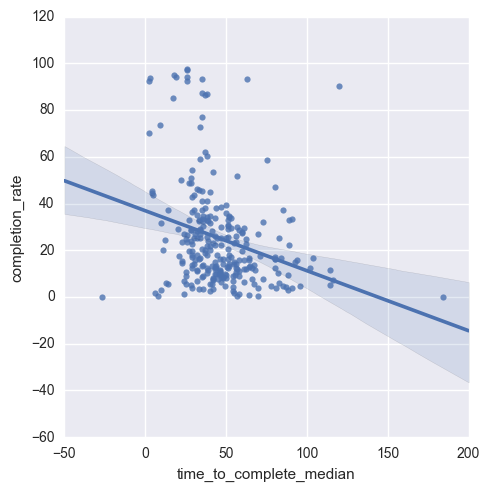

In [46]:
sns.lmplot(data = df_merged[df_merged['user_id_counts'] > 200],
          x = 'time_to_complete_median',
          y = 'completion_rate')